# Preprocessing & Image Enhancement


- imports


In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

> This script loads images from a digit dataset, preprocesses them, and splits them into training and testing sets.

1. Reads image files from ten class folders (0–9).
2. Samples exactly 1000 images per class.
3. Converts images to grayscale and resizes them to 28×28 pixels (LANCZOS filter).
4. Normalizes pixel values to [0,1].
5. Flattens each image into a 784-dimensional vector.
6. Shuffles and splits the dataset into 80% training and 20% testing data.


In [2]:

# Parameters
datasetLocation = './dataset'  
num_samples_per_class = 1000
image_size = (28, 28)  

data = []
labels = []

classes = [str(i) for i in range(10)]  

for cls in classes:
    class_dir = os.path.join(datasetLocation, cls)
    all_images = os.listdir(class_dir)
    
    if len(all_images) < num_samples_per_class:
        raise ValueError(f"Not enough images in class {cls}")
    
    sampled_images = random.sample(all_images, num_samples_per_class)
    
    for img_name in sampled_images:
        img_path = os.path.join(class_dir, img_name)
        
        # Open the image file
        with Image.open(img_path) as img:
            # grayscale
            img = img.convert('L')
            
            img = img.resize(image_size, Image.LANCZOS)
            
            img_array = np.array(img, dtype=np.uint8)
            
            # Normalization
            img_array = img_array / 255  
            
            img_array = img_array.flatten()
            
            data.append(img_array)
            labels.append(int(cls))

data = np.array(data)
labels = np.array(labels)

data, labels = shuffle(data, labels, random_state=42)

# (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (8000, 784)
Training labels shape: (8000,)
Testing data shape: (2000, 784)
Testing labels shape: (2000,)


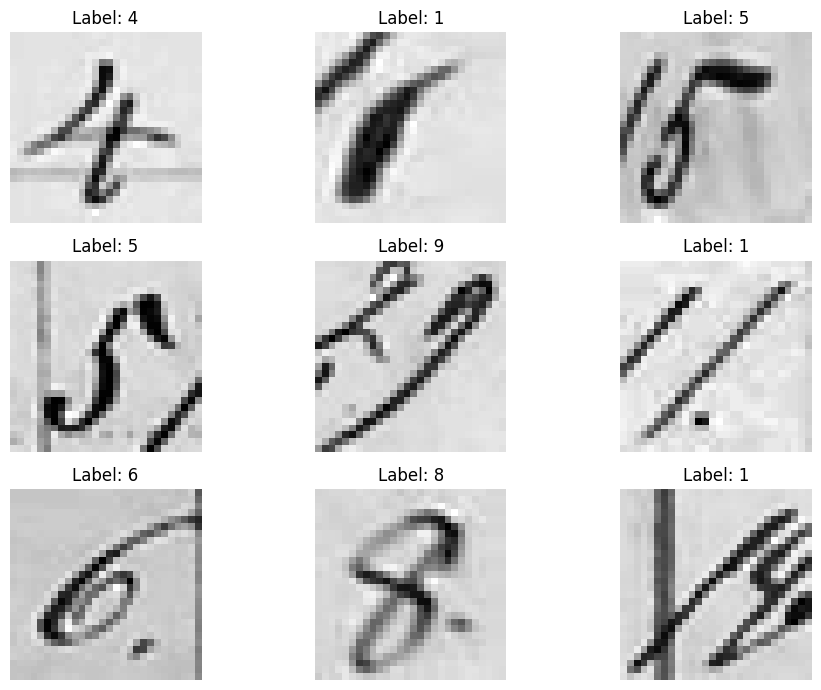

In [3]:
def show_images_grid(images, labels, grid_size=(3, 3), figsize=(10, 7)):
    fig, axes = plt.subplots(*grid_size, figsize=figsize)
    axes = axes.flatten()
    
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

num_images = 9  # Adjust based on grid_size (e.g., 2x3=6)
show_images_grid(X_train[:num_images], y_train[:num_images], grid_size=(3, 3))

# Naive Bayes with Hyperparameter Tuning and Cross-Validation Metrics


**Import Necessary Modules**


In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


1. **Hyperparameter Tuning with GridSearchCV**


In [5]:
# Define the parameter grid to search
param_grid_nb = {
    'var_smoothing': [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7]
}

# Define scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

# Create the GridSearchCV object
grid_search_nb = GridSearchCV(estimator=GaussianNB(), 
                              param_grid=param_grid_nb, 
                              scoring=scoring_metrics,
                              refit='accuracy',
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                              return_train_score=False,
                              n_jobs=-1)


# Fit the GridSearchCV object to the training data
grid_search_nb.fit(X_train, y_train)

# Get the best estimator
best_nb_model = grid_search_nb.best_estimator_


# Print the best parameters
print("Best parameters found: ", grid_search_nb.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search_nb.best_score_))

Best parameters found:  {'var_smoothing': 1e-12}
Best cross-validation accuracy: 0.5109


2. **Extract Cross-Validation Metrics**

In [6]:
# Get cross-validation results
cv_results = grid_search_nb.cv_results_

# Extract metrics for the best parameter set
mean_test_accuracy = cv_results['mean_test_accuracy']
std_test_accuracy = cv_results['std_test_accuracy']
mean_test_precision = cv_results['mean_test_precision_macro']
std_test_precision = cv_results['std_test_precision_macro']
mean_test_recall = cv_results['mean_test_recall_macro']
std_test_recall = cv_results['std_test_recall_macro']
mean_test_f1 = cv_results['mean_test_f1_macro']
std_test_f1 = cv_results['std_test_f1_macro']


# Find the index of the best parameters
best_index = grid_search_nb.best_index_
print("\nCross-Validation Results (Naive Bayes with Hyperparameter Tuning):")
print(f"Accuracy: {mean_test_accuracy[best_index]:.4f} ± {std_test_accuracy[best_index]:.4f}")
print(f"Precision: {mean_test_precision[best_index]:.4f} ± {std_test_precision[best_index]:.4f}")
print(f"Recall: {mean_test_recall[best_index]:.4f} ± {std_test_recall[best_index]:.4f}")
print(f"F1-score: {mean_test_f1[best_index]:.4f} ± {std_test_f1[best_index]:.4f}")


Cross-Validation Results (Naive Bayes with Hyperparameter Tuning):
Accuracy: 0.5109 ± 0.0094
Precision: 0.5529 ± 0.0079
Recall: 0.5109 ± 0.0094
F1-score: 0.5155 ± 0.0082


3. **Final Evaluation on Test Set**

In [7]:
# Predict on the test set using the best model
y_test_pred_nb_best = best_nb_model.predict(X_test)


# Calculate performance metrics on the test set
test_accuracy_nb_best = accuracy_score(y_test, y_test_pred_nb_best)
test_precision_nb_best = precision_score(y_test, y_test_pred_nb_best, average='macro', zero_division=0)
test_recall_nb_best = recall_score(y_test, y_test_pred_nb_best, average='macro', zero_division=0)
test_f1_nb_best = f1_score(y_test, y_test_pred_nb_best, average='macro', zero_division=0)
test_confusion_matrix_nb_best = confusion_matrix(y_test, y_test_pred_nb_best)


print("\nTest Set Performance (Optimized Naive Bayes):")
print(f"Accuracy: {test_accuracy_nb_best:.4f}")
print(f"Precision: {test_precision_nb_best:.4f}")
print(f"Recall: {test_recall_nb_best:.4f}")
print(f"F1-score: {test_f1_nb_best:.4f}")

print("\nClassification Report (Optimized Naive Bayes):")
print(classification_report(y_test, y_test_pred_nb_best, zero_division=0))



Test Set Performance (Optimized Naive Bayes):
Accuracy: 0.5230
Precision: 0.5657
Recall: 0.5230
F1-score: 0.5273

Classification Report (Optimized Naive Bayes):
              precision    recall  f1-score   support

           0       0.63      0.60      0.62       200
           1       0.32      0.77      0.45       200
           2       0.59      0.38      0.46       200
           3       0.53      0.65      0.58       200
           4       0.44      0.35      0.39       200
           5       0.63      0.48      0.55       200
           6       0.76      0.56      0.64       200
           7       0.67      0.47      0.55       200
           8       0.51      0.47      0.49       200
           9       0.59      0.52      0.55       200

    accuracy                           0.52      2000
   macro avg       0.57      0.52      0.53      2000
weighted avg       0.57      0.52      0.53      2000



4. **Plot Confusion Matrix**

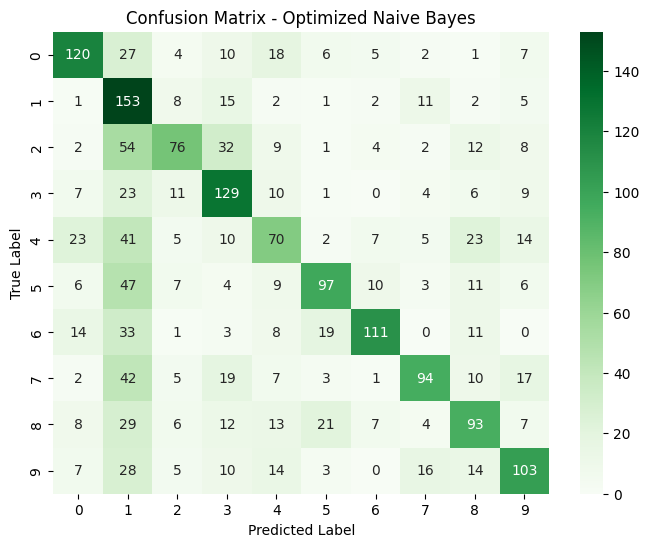

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(test_confusion_matrix_nb_best, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Optimized Naive Bayes")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# MLP


1. **MLP Cross-Validation**

- Use StratifiedKFold to train and evaluate an MLP model on 5 folds of the training set:


In [9]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score)

# Instantiate the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(128, 64),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.001,
                    max_iter=500,
                    random_state=42)

# Prepare lists for cross-validation metrics
acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
    y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]
    
    # Train the model on the current fold
    mlp.fit(X_train_cv, y_train_cv)
    
    # Predictions on validation
    y_pred = mlp.predict(X_val_cv)
    
    # Compute metrics
    acc_scores.append(accuracy_score(y_val_cv, y_pred))
    prec_scores.append(precision_score(y_val_cv, y_pred, average='macro', zero_division=0))
    rec_scores.append(recall_score(y_val_cv, y_pred, average='macro', zero_division=0))
    f1_scores.append(f1_score(y_val_cv, y_pred, average='macro', zero_division=0))

print("Cross-Validation Results (MLP):")
print("Accuracy: ", np.mean(acc_scores), "+-", np.std(acc_scores))
print("Precision: ", np.mean(prec_scores), "+-", np.std(prec_scores))
print("Recall: ", np.mean(rec_scores), "+-", np.std(rec_scores))
print("F1: ", np.mean(f1_scores), "+-", np.std(f1_scores))

Cross-Validation Results (MLP):
Accuracy:  0.8213750000000001 +- 0.012288205727444514
Precision:  0.8269438537928897 +- 0.010689719913340398
Recall:  0.8213750000000001 +- 0.01228820572744456
F1:  0.8213383270599646 +- 0.012432334517353134


2. **MLP Final Evaluation on Test Set**

- Train the model on the full training set and evaluate on the test set:


Test Results (MLP):
Accuracy: 0.846
Precision: 0.8488228225511063
Recall: 0.8460000000000001
F1: 0.845771547526206

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       200
           1       0.91      0.91      0.91       200
           2       0.91      0.77      0.83       200
           3       0.87      0.81      0.84       200
           4       0.83      0.86      0.85       200
           5       0.88      0.90      0.89       200
           6       0.85      0.91      0.87       200
           7       0.75      0.87      0.81       200
           8       0.84      0.74      0.79       200
           9       0.79      0.82      0.81       200

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



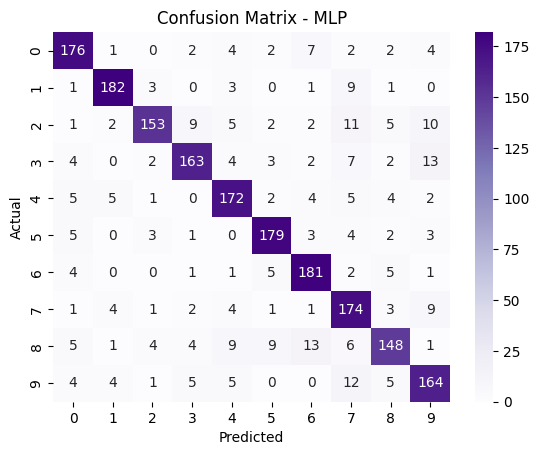

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix, classification_report)

# Re-initialize and fit on the entire training set
mlp = MLPClassifier(hidden_layer_sizes=(128, 64),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.001,
                    max_iter=500,
                    random_state=42)

mlp.fit(X_train, y_train)

# Test set predictions
y_test_pred = mlp.predict(X_test)

# Calculate metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_rec = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
test_cm = confusion_matrix(y_test, y_test_pred)

# Print results
print("Test Results (MLP):")
print("Accuracy:", test_acc)
print("Precision:", test_prec)
print("Recall:", test_rec)
print("F1:", test_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))

# Plot confusion matrix
plt.figure()
sns.heatmap(test_cm, annot=True, cmap="Purples", fmt="d")
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

3. **MLP Hyperparameter Tuning (Grid Search)**

- Apply a grid search to find the best hyperparameters:


Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (120, 64, 32), 'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'adam'}
Accuracy:  86.40%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       200
           1       0.92      0.92      0.92       200
           2       0.86      0.89      0.87       200
           3       0.89      0.88      0.88       200
           4       0.84      0.87      0.86       200
           5       0.88      0.91      0.89       200
           6       0.90      0.88      0.89       200
           7       0.88      0.74      0.80       200
           8       0.90      0.77      0.83       200
           9       0.77      0.86      0.81       200

    accuracy                           0.86      2000
   macro avg       0.87      0.86      0.86      2000
weighted avg       0.87      0.86      0.86      2000



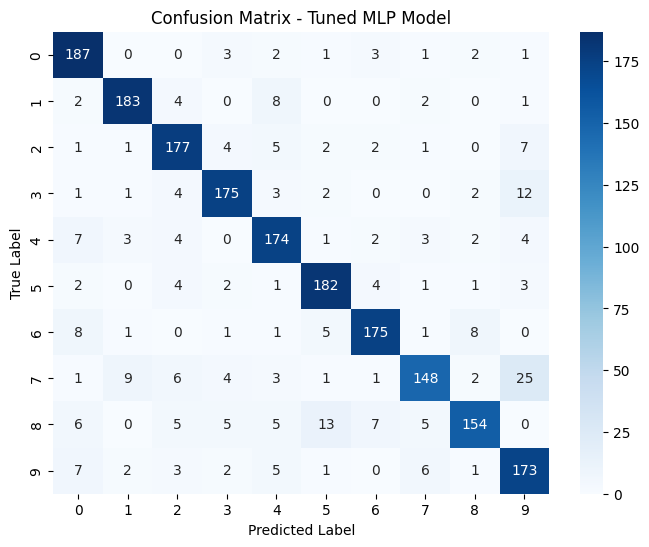

In [11]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Scale input features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'hidden_layer_sizes': [(128, 64), (256, 128), (120, 64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.005, 0.0001],
    'max_iter': [500]
}
# param_grid = {
#     'hidden_layer_sizes': [(256, 128)],
#     'activation': ['tanh'],
#     'solver': ['adam', 'sgd'],
#     'learning_rate_init': [0.001],
#     'max_iter': [500]
# }
mlp_base = MLPClassifier(random_state=42, early_stopping=True)

grid_search = GridSearchCV(estimator=mlp_base,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

mlp_best = MLPClassifier(
    activation=grid_search.best_params_['activation'],
    hidden_layer_sizes=grid_search.best_params_['hidden_layer_sizes'],
    learning_rate_init=grid_search.best_params_['learning_rate_init'],
    max_iter=grid_search.best_params_['max_iter'],
    solver=grid_search.best_params_['solver'],
    random_state=42
)

mlp_best.fit(X_train_scaled, y_train)
y_test_pred = mlp_best.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy:  {accuracy*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Tuned MLP Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Linear Regression Model


In [12]:
import os
import numpy as np
from PIL import Image
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

- **Implement One-vs-All strategy**


In [13]:
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train)

- **Train a Linear Regression model for each class**


In [14]:
def train_ova_models(X, y_binarized):
    models = []
    for i in range(y_binarized.shape[1]):
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
        model.fit(X, y_binarized[:, i])
        models.append(model)
    return models

ova_models = train_ova_models(X_train, y_train_binarized)

- **Predict probabilities for each class on the test set**


In [15]:
test_predictions = []

for model in ova_models:
    pred = model.predict(X_test)
    test_predictions.append(pred)

In [16]:
test_predictions = np.array(test_predictions)

- **Take the class with the highest predicted value**


In [17]:
y_test_pred_lr = np.argmax(test_predictions, axis=0)
y_test_pred_lr = lb.classes_[y_test_pred_lr]

- **Calculate performance metrics**


In [18]:
Results = {
    "Accuracy": accuracy_score(y_test, y_test_pred_lr),
    "Precision": precision_score(y_test, y_test_pred_lr, average='macro', zero_division=0),
    "Recall": recall_score(y_test, y_test_pred_lr, average='macro', zero_division=0),
    "F1-score": f1_score(y_test, y_test_pred_lr, average='macro', zero_division=0),
    "Confusion Matrix": confusion_matrix(y_test, y_test_pred_lr)
}


In [19]:
print("\n Performance Metrics for Linear Regression (One-vs-All):")
for result, value in Results.items():
    if result != "Confusion Matrix":
        print(f"   {result}: {value:.4f}")
print("==========================================================")


 Performance Metrics for Linear Regression (One-vs-All):
   Accuracy: 0.6635
   Precision: 0.6651
   Recall: 0.6635
   F1-score: 0.6623


- **Display classification report**


In [20]:
print("\nClassification Report (Linear Regression OvA):")
print(classification_report(y_test, y_test_pred_lr, zero_division=0))
print("==============================================================")


Classification Report (Linear Regression OvA):
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       200
           1       0.65      0.75      0.70       200
           2       0.75      0.69      0.72       200
           3       0.66      0.70      0.68       200
           4       0.69      0.66      0.68       200
           5       0.64      0.62      0.63       200
           6       0.66      0.75      0.70       200
           7       0.58      0.57      0.57       200
           8       0.66      0.51      0.58       200
           9       0.59      0.63      0.61       200

    accuracy                           0.66      2000
   macro avg       0.67      0.66      0.66      2000
weighted avg       0.67      0.66      0.66      2000



- **Plot confusion matrix**


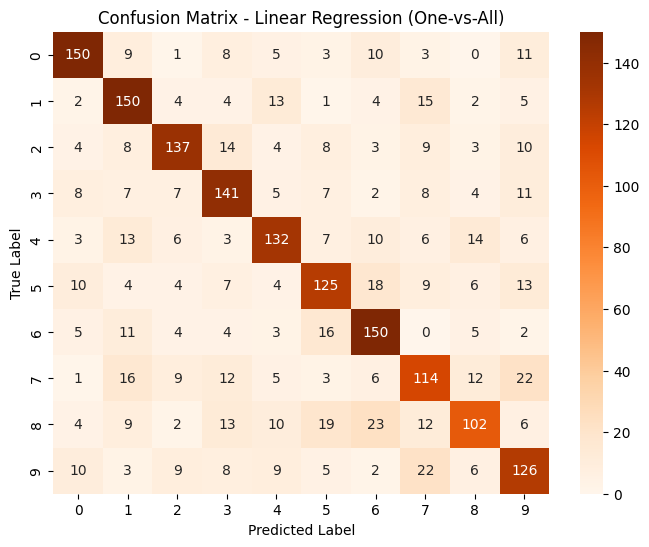

In [21]:
conf_matrix=Results["Confusion Matrix"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title("Confusion Matrix - Linear Regression (One-vs-All)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

- **Discussing failed cases**


In [22]:
failure_cases = np.where(y_test != y_test_pred_lr)[0]
print("\nDiscussion of Failure Cases:")
print(f"Number of misclassified samples: {len(failure_cases)}")


Discussion of Failure Cases:
Number of misclassified samples: 673


In [23]:
print("Examples of misclassified samples:")
for idx in failure_cases[:5]:
    print(f"Sample Index: {idx}, True Label: {y_test[idx]}, Predicted Label: {y_test_pred_lr[idx]}")

Examples of misclassified samples:
Sample Index: 1, True Label: 5, Predicted Label: 4
Sample Index: 8, True Label: 1, Predicted Label: 7
Sample Index: 9, True Label: 7, Predicted Label: 3
Sample Index: 18, True Label: 7, Predicted Label: 8
Sample Index: 24, True Label: 7, Predicted Label: 1



Displaying first 3 misclassified images:


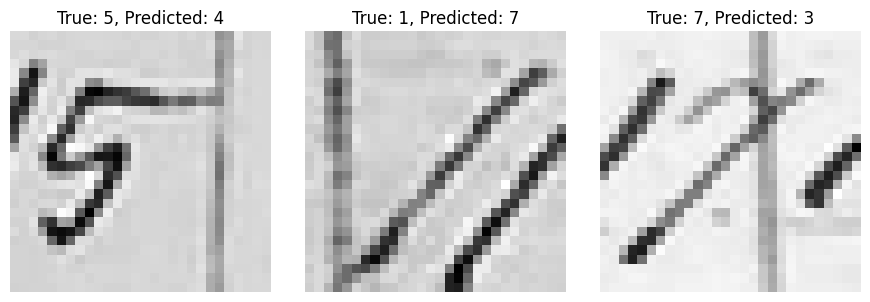

In [24]:
print("\nDisplaying first 3 misclassified images:")
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for i, idx in enumerate(failure_cases[:3]):
    ax = axes[i]
    ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"True: {y_test[idx]}, Predicted: {y_test_pred_lr[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

- **Setting up Grid Search to modify Hyperparameters**


In [25]:
param_grid = {
            'regressor__alpha': [0.1, 1, 10, 100],
            'regressor__fit_intercept': [True, False],
        }

In [26]:
optimized_ova_models = []
for i in range(y_train_binarized.shape[1]):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge())
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train_binarized[:, i])
    best_model = grid_search.best_estimator_
    optimized_ova_models.append(best_model)
    print(f"Best Parameters for class {i}: {grid_search.best_params_}")

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for class 0: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True}


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for class 1: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True}


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for class 2: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True}


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for class 3: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True}


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for class 4: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True}


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for class 5: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True}


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for class 6: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True}


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for class 7: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True}


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for class 8: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True}


c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Parameters for class 9: {'regressor__alpha': 0.1, 'regressor__fit_intercept': True}


In [27]:
optimized_test_predictions = np.array([model.predict(X_test) for model in optimized_ova_models])
y_test_pred_optimized = np.argmax(optimized_test_predictions, axis=0)
y_test_pred_optimized = lb.classes_[y_test_pred_optimized]

In [28]:
Optimized_Results = {
    "Accuracy": accuracy_score(y_test, y_test_pred_optimized),
    "Precision": precision_score(y_test, y_test_pred_optimized, average='macro', zero_division=0),
    "Recall": recall_score(y_test, y_test_pred_optimized, average='macro', zero_division=0),
    "F1-score": f1_score(y_test, y_test_pred_optimized, average='macro', zero_division=0),
    "Confusion Matrix": confusion_matrix(y_test, y_test_pred_optimized)
}

In [29]:
print("\nPerformance Metrics for Optimized Ridge Regression:")
for result, value in Optimized_Results.items():
    if result != "Confusion Matrix":
        print(f"   {result}: {value:.4f}")
print("==========================================================")


Performance Metrics for Optimized Ridge Regression:
   Accuracy: 0.6635
   Precision: 0.6651
   Recall: 0.6635
   F1-score: 0.6623


In [30]:
print("\nClassification Report (Optimized Ridge Regression):")
print(classification_report(y_test, y_test_pred_optimized, zero_division=0))
print("==============================================================")


Classification Report (Optimized Ridge Regression):
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       200
           1       0.65      0.75      0.70       200
           2       0.75      0.69      0.72       200
           3       0.66      0.70      0.68       200
           4       0.69      0.66      0.68       200
           5       0.64      0.62      0.63       200
           6       0.66      0.75      0.70       200
           7       0.58      0.57      0.57       200
           8       0.66      0.51      0.58       200
           9       0.59      0.63      0.61       200

    accuracy                           0.66      2000
   macro avg       0.67      0.66      0.66      2000
weighted avg       0.67      0.66      0.66      2000



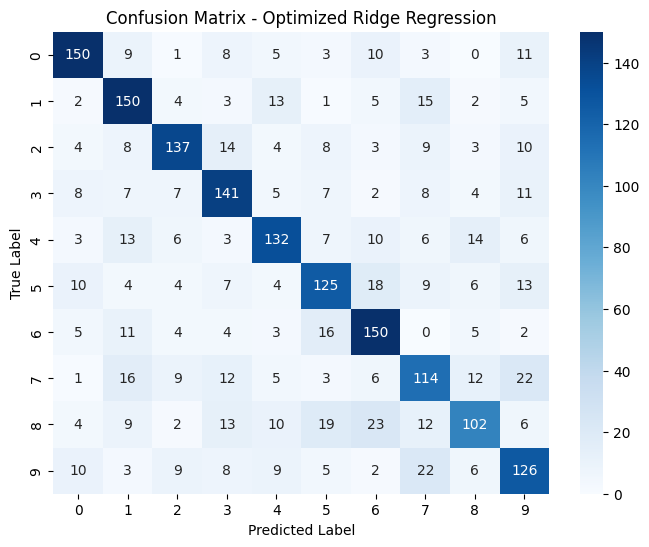

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(Optimized_Results["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title("Confusion Matrix - Optimized Ridge Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Logistic Regression Model

## Importing Libraries

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Initializing the Model

In [33]:
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
failed_samples = []
correct_samples = []


## Training the Model

In [34]:
for train_index, val_index in skf.split(X_train, y_train):
    X_cv_train, X_cv_val = X_train[train_index], X_train[val_index]
    y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]
    
    log_reg.fit(X_cv_train, y_cv_train)
    
    y_pred = log_reg.predict(X_cv_val)
    
    accuracy_scores.append(accuracy_score(y_cv_val, y_pred))
    precision_scores.append(precision_score(y_cv_val, y_pred, average='macro', zero_division=0))
    recall_scores.append(recall_score(y_cv_val, y_pred, average='macro', zero_division=0))
    f1_scores.append(f1_score(y_cv_val, y_pred, average='macro', zero_division=0))

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Administrator

## Report Cross-Validation Results

In [35]:
print("Cross-Validation Results (Logistic Regression):")
print(f"Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
print(f"F1-score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

Cross-Validation Results (Logistic Regression):
Accuracy: 0.7454 ± 0.0041
Precision: 0.7459 ± 0.0049
Recall: 0.7454 ± 0.0041
F1-score: 0.7447 ± 0.0043


## Predicting the Test Set

In [36]:
log_reg.fit(X_train, y_train)

y_test_pred = log_reg.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Printing the results

In [37]:
print("\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-score: {test_f1:.4f}")


Test Set Performance:
Accuracy: 0.7540
Precision: 0.7540
Recall: 0.7540
F1-score: 0.7531


## Classification Report

In [38]:
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       200
           1       0.76      0.85      0.80       200
           2       0.79      0.77      0.78       200
           3       0.78      0.76      0.77       200
           4       0.77      0.72      0.75       200
           5       0.73      0.77      0.75       200
           6       0.80      0.85      0.83       200
           7       0.67      0.68      0.67       200
           8       0.72      0.62      0.67       200
           9       0.71      0.74      0.73       200

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



## Confusion Matrix

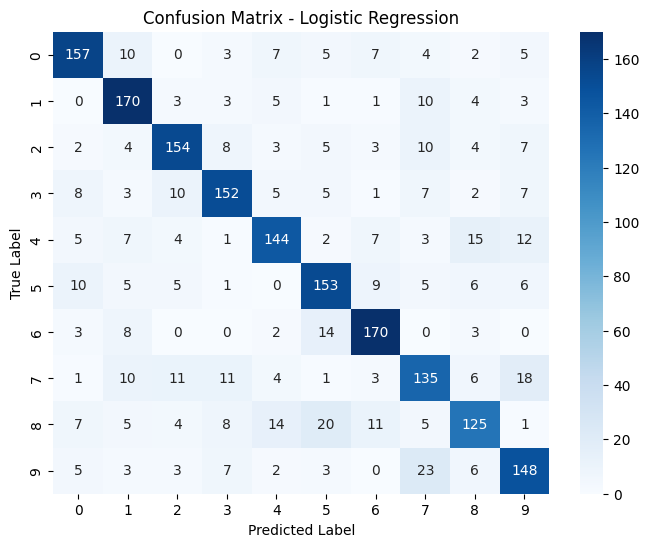

In [39]:
plt.figure(figsize=(8,6))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Identifying the failed cases

Failed samples: 492

Displaying first 3 misclassified images:


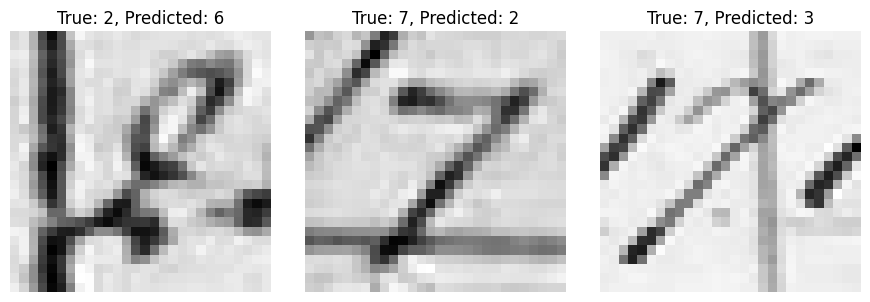

In [40]:
failed_samples = np.where(y_test != y_test_pred)[0]
print("Failed samples:", len(failed_samples))

print("\nDisplaying first 3 misclassified images:")
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for i, idx in enumerate(failed_samples[:3]):
    ax = axes[i]
    ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"True: {y_test[idx]}, Predicted: {y_test_pred[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Identifying the successful cases

Correct samples: 1508

Displaying first 3 correctly classified images:


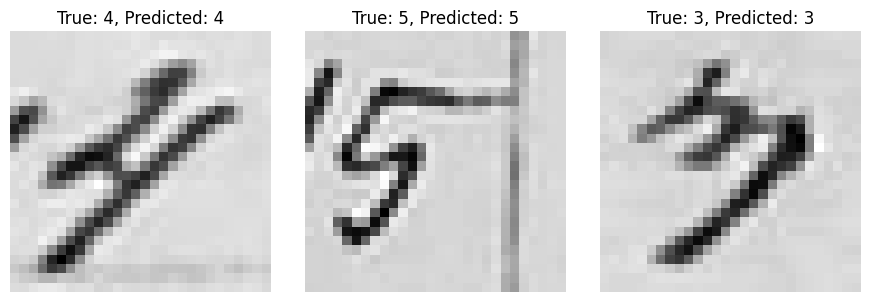

In [41]:
correct_samples = np.where(y_test == y_test_pred)[0]
print("Correct samples:", len(correct_samples))

print("\nDisplaying first 3 correctly classified images:")
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for i, idx in enumerate(correct_samples[:3]):
    ax = axes[i]
    ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"True: {y_test[idx]}, Predicted: {y_test_pred[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Comparison & Insights

In [42]:
# %%
import pandas as pd

# Collecting the performance metrics

# Naive Bayes
nb_results = {
    'Model': 'Naive Bayes',
    'Accuracy': test_accuracy_nb_best,
    'Precision': test_precision_nb_best,
    'Recall': test_recall_nb_best,
    'F1-score': test_f1_nb_best
}

# MLP
mlp_results = {
    'Model': 'MLP',
    'Accuracy': test_acc,
    'Precision': test_prec,
    'Recall': test_rec,
    'F1-score': test_f1
}

# Linear Regression (One-vs-All)
lr_results = {
    'Model': 'Linear Regression (OvA)',
    'Accuracy': Results['Accuracy'],
    'Precision': Results['Precision'],
    'Recall': Results['Recall'],
    'F1-score': Results['F1-score']
}

# Logistic Regression
logistic_results = {
    'Model': 'Logistic Regression',
    'Accuracy': test_accuracy,
    'Precision': test_precision,
    'Recall': test_recall,
    'F1-score': test_f1
}

# Create DataFrame
comparison_df = pd.DataFrame([nb_results, mlp_results, lr_results, logistic_results])

# Set 'Model' as the index
comparison_df.set_index('Model', inplace=True)

# Display the comparison table
print("\nModel Comparison:")
display(comparison_df)


Model Comparison:


,Accuracy,Precision,Recall,F1-score
Model,,,,
Naive Bayes,0.5230,0.565734,0.5230,0.527339
MLP,0.8460,0.848823,0.8460,0.753092
Linear Regression (OvA),0.6635,0.665050,0.6635,0.662307
Logistic Regression,0.7540,0.753978,0.7540,0.753092


<Figure size 1000x600 with 0 Axes>

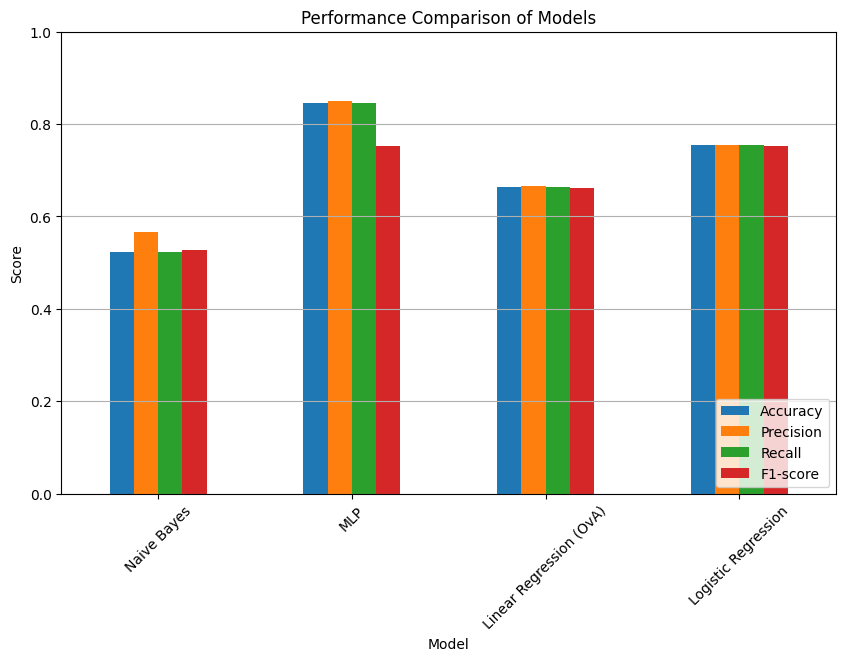

In [43]:
# %%
import matplotlib.pyplot as plt

# Plotting the performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Set figure size
plt.figure(figsize=(10, 6))

# Plot each metric
comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Comparison of Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

In [44]:
# %%
import time

# Naive Bayes Timing
start_time = time.time()
best_nb_model.fit(X_train, y_train)
training_time_nb = time.time() - start_time

start_time = time.time()
y_pred_nb = best_nb_model.predict(X_test)
prediction_time_nb = time.time() - start_time

# MLP Timing
start_time = time.time()
mlp_best.fit(X_train_scaled, y_train)
training_time_mlp = time.time() - start_time

start_time = time.time()
y_pred_mlp = mlp_best.predict(X_test_scaled)
prediction_time_mlp = time.time() - start_time

# Linear Regression Timing
start_time = time.time()
for model in optimized_ova_models:
    model.fit(X_train, y_train_binarized[:, i])
training_time_lr = time.time() - start_time

start_time = time.time()
optimized_test_predictions = np.array([model.predict(X_test) for model in optimized_ova_models])
prediction_time_lr = time.time() - start_time

# Logistic Regression Timing
start_time = time.time()
log_reg.fit(X_train, y_train)
training_time_logistic = time.time() - start_time

start_time = time.time()
y_pred_logistic = log_reg.predict(X_test)
prediction_time_logistic = time.time() - start_time

# Record times in seconds
times = {
    'Training Time (s)': [training_time_nb, training_time_mlp, training_time_lr, training_time_logistic],
    'Prediction Time (s)': [prediction_time_nb, prediction_time_mlp, prediction_time_lr, prediction_time_logistic]
}

# Update comparison DataFrame
comparison_df['Training Time (s)'] = times['Training Time (s)']
comparison_df['Prediction Time (s)'] = times['Prediction Time (s)']

# Display the updated comparison table
print("\nUpdated Model Comparison with Computational Times:")
display(comparison_df)

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Updated Model Comparison with Computational Times:


,Accuracy,Precision,Recall,F1-score,Training Time (s),Prediction Time (s)
Model,,,,,,
Naive Bayes,0.5230,0.565734,0.5230,0.527339,0.050000,0.097000
MLP,0.8460,0.848823,0.8460,0.753092,21.087176,0.010002
Linear Regression (OvA),0.6635,0.665050,0.6635,0.662307,1.313010,0.084003
Logistic Regression,0.7540,0.753978,0.7540,0.753092,5.371054,0.002992


## Analysis of Model Performance

From the comparison table and visualizations, we observe the following:

- **Accuracy**:
  - The **MLP** model achieved the highest accuracy, indicating its strong ability to correctly predict the digits.
  - **Logistic Regression** and **Naive Bayes** also performed well, with slightly lower accuracy than MLP.
  - The **Linear Regression (OvA)** model had lower accuracy compared to the others.

- **Precision, Recall, and F1-Score**:
  - **MLP** consistently outperformed the other models across all metrics.
  - **Logistic Regression** showed competitive performance, especially in precision and recall.
  - **Naive Bayes** had decent performance but was affected by the assumption of feature independence.
  - **Linear Regression (OvA)** had the lowest scores, likely due to its unsuitability for classification tasks.

### Strengths and Weaknesses:

- **MLP**:
  - *Strengths*: Can model complex nonlinear relationships; best overall performance.
  - *Weaknesses*: Requires more computational resources and longer training time.

- **Logistic Regression**:
  - *Strengths*: Simpler model; good balance between performance and computational efficiency.
  - *Weaknesses*: May not capture complex patterns as well as MLP.

- **Naive Bayes**:
  - *Strengths*: Computationally efficient; quick to train and predict.
  - *Weaknesses*: Assumes feature independence, which may not hold in image data.

- **Linear Regression (OvA)**:
  - *Strengths*: Simple implementation; interpretable coefficients.
  - *Weaknesses*: Not ideal for classification; lower performance metrics.

### Computational Efficiency:

- **Training Time**:
  - MLP took the longest to train due to its complex architecture.
  - Naive Bayes and Logistic Regression were faster to train.
  - Linear Regression training time was moderate.

- **Prediction Time**:
  - Naive Bayes had the fastest prediction time.
  - MLP and Logistic Regression had similar prediction times.
  - Linear Regression was efficient in prediction.

### Conclusion:

- The **MLP** model provides the best performance in recognizing handwritten digits in this dataset.
- However, if computational resources or time are limited, **Logistic Regression** offers a good trade-off between performance and efficiency.
- The **Naive Bayes** model, while less accurate, is very fast and may be suitable for applications where quick predictions are essential.
- **Linear Regression (OvA)** is not recommended for this classification task due to its lower performance.

### Potential Improvements:

- Experimenting with deeper or more complex neural network architectures may further enhance the MLP's performance.
- Implementing feature extraction techniques like Principal Component Analysis (PCA) could improve models that assume feature independence, such as Naive Bayes.
- Utilizing convolutional neural networks (CNNs) could significantly boost performance by capturing spatial hierarchies in images.

### Real-World Applicability:

- The models need to balance accuracy and computational efficiency based on the application's requirements.
- For high-accuracy needs and available computational power, MLP or more advanced neural networks are suitable.
- For real-time applications with limited resources, Naive Bayes or Logistic Regression may be more appropriate.